# Setup

In [3]:
from Data.data_dicts import character_dict

import pandas as pd
from tqdm import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt

In [4]:
characters = list(character_dict.keys())
characters.remove('Default')

In [5]:
# Mount google drive, if in Colaboratory environment
import os
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    base_folder = '/content/drive/My Drive/unibo/NLP_project/BarneyBot'
    os.system("pip install datasets")
    os.system("pip install transformers")
    os.system("pip install rouge_score")
    os.system("pip install -U sentence-transformers")
else:
    base_folder = os.getcwd()

# Define input and output folders for chosen character
in_folder = os.path.join(base_folder, 'Data', 'Characters')
if not os.path.exists(in_folder):
    os.makedirs(in_folder)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

In [7]:
character_docs = dict()
for character in characters:
    df = pd.read_csv(os.path.join(in_folder, character, f'{character}.csv'))
    character_docs[character] = df['response'].tolist()

In [8]:
for character in characters:
    for i in tqdm(range(len(character_docs[character]))):
        character_docs[character][i] = re.sub(r'[^A-Za-z\s]', ' ', character_docs[character][i])
        character_docs[character][i] = re.sub(r'\s+', ' ', character_docs[character][i])

100%|██████████████████████████████████████████████████████████████████████████| 7476/7476 [00:00<00:00, 140016.15it/s]


In [9]:
def filter_by_weights(wordweights, mass):
    N = sum([v for v in wordweights.values()])
    n = 0
    filteredfreq = dict()
    for key, value in sorted(wordweights.items(), key=lambda k: k[1], reverse=True):
        n += value
        if n / N < mass:
            filteredfreq[key] = value
    return filteredfreq

# Word Frequency

In [10]:
def get_word_frequency(doc):
    wordlist = doc.lower().split()
    _temp = list()
    words = set(wordlist)
    wordfreq = {w: wordlist.count(w) for w in words}
    orderedfreq = dict()
    print("Removing stopwords")
    for k, v in tqdm(sorted(wordfreq.items(), key=lambda k: k[1], reverse=True)):
        if k not in stopwords.words():
            orderedfreq[k] = v
    return orderedfreq

In [200]:
wordfreqs = dict()
for character in characters:
    wordfreqs[character] = get_word_frequency(' '.join(character_docs[character]))

Removing stopwords


100%|█████████████████████████████████████████████████████████████████████████████| 6539/6539 [01:01<00:00, 105.51it/s]


Removing stopwords


100%|███████████████████████████████████████████████████████████████████████████| 13902/13902 [02:03<00:00, 112.78it/s]


Removing stopwords


100%|█████████████████████████████████████████████████████████████████████████████| 1002/1002 [00:09<00:00, 110.60it/s]


Removing stopwords


100%|█████████████████████████████████████████████████████████████████████████████| 3698/3698 [00:33<00:00, 111.69it/s]


Removing stopwords


100%|█████████████████████████████████████████████████████████████████████████████| 3994/3994 [00:36<00:00, 110.08it/s]


Removing stopwords


100%|███████████████████████████████████████████████████████████████████████████████| 576/576 [00:05<00:00, 108.03it/s]


Removing stopwords


100%|█████████████████████████████████████████████████████████████████████████████| 5314/5314 [00:47<00:00, 112.59it/s]


Removing stopwords


100%|█████████████████████████████████████████████████████████████████████████████| 5454/5454 [00:47<00:00, 113.87it/s]


In [211]:
wordfreqs_reduced = dict()
for character in characters:
    wordfreqs_reduced[character] = filter_by_weights(wordfreqs[character], mass=0.3)

# TF-IDF

In [11]:
tfidf_vectorizer = TfidfVectorizer(input='content', stop_words='english')

def get_tfidfs(docs, characters, vectorizer):
    tfidf_matrix = tfidf_vectorizer.fit_transform(docs)
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=characters, columns=tfidf_vectorizer.get_feature_names())
    tfidfs = dict()
    for i in range(len(characters)):
        tfidf_char = tfidf_df.loc[characters[i]].to_dict()
        tfidfs[characters[i]] = dict()
        for key, value in sorted(tfidf_char.items(), key=lambda k: k[1], reverse=True):
            tfidfs[characters[i]][key] = value
    return tfidfs

In [ ]:
tfidfs = get_tfidfs([' '.join(character_docs[character]) for character in characters], characters, tfidf_vectorizer)

In [215]:
tfidfs_reduced = dict()
for character in characters:
    tfidfs_reduced[character] = filter_by_weights(tfidfs[character], mass=0.3)

# WordCloud Plot

In [12]:
from wordcloud import WordCloud

def plot_word_cloud(freqdict, cmap='viridis', title=None, plot=False):
    wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      colormap = cmap, max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0)

    wordcloud.generate_from_frequencies(freqdict)
    if title:
        plt.title(title)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figure()

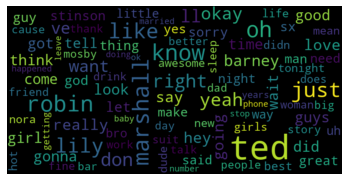

<Figure size 432x288 with 0 Axes>

In [248]:
plot_word_cloud(tfidfs_reduced['Barney'])

# Frequency Pairwise Similarity

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

def freq_pairwise_sim(v1, v2):
    wordset = set(v1.keys()).union((v2.keys()))
    v1_ord = list()
    v2_ord = list()
    for w in wordset:
        v1_ord.append(v1.get(w, 0.0))
        v2_ord.append(v2.get(w, 0.0))
    return cosine_similarity(np.array(v1_ord).reshape(1, -1), np.array(v2_ord).reshape(1, -1))[0][0]

In [235]:
freq_pairwise_sim(tfidfs_reduced['Fry'], tfidfs_reduced['Barney'])

0.435295514926768

# Frequency Classifier

In [16]:
class FrequencyChatbotClassifier:
    def __init__(self, characters, mode):
        self.characters = characters
        if mode != "word frequency" and mode != "tf-idf":
            raise Exception("Unknown mode!")
        self.mode = mode
        self.loaded = False
        self.model = None
    
    def train(self, docs):
        self.model = None
        self.loaded = False
        if len(docs) != len(self.characters):
            raise Exception("Mismatch between classifier classes and provided documents!")
        docs = [' '.join(doc) for doc in docs]
        if self.mode == 'word frequency':
            self.model = dict()
            for i in range(len(self.characters)):
                self.model[self.characters[i]] = get_word_frequency(docs[i])
        elif self.mode == 'tf-idf':
            self.model = {'vectorizer': TfidfVectorizer(input='content', stop_words='english'), 'docs': docs}
        self.loaded = True
    
    def predict(self, doc, mass=0.5):
        if not self.loaded:
            raise Exception("Classifier must be trained first!")
        doc = ' '.join(doc)
        predictions = dict()
        if self.mode == 'word frequency':
            v1 = filter_by_weights(get_word_frequency(doc), mass)
        elif self.mode == 'tf-idf':
            doc_names = self.characters.copy()
            doc_names.append('input')
            all_docs = self.model['docs'].copy()
            all_docs.append(doc)
            tfidfs = get_tfidfs(all_docs, doc_names, self.model['vectorizer'])
            v1 = filter_by_weights(tfidfs['input'], mass)
        for character in self.characters:
            if self.mode == 'word frequency':
                w = self.model[character]
            elif self.mode == 'tf-idf':
                w = tfidfs[character]
            v2 = filter_by_weights(w, mass)
            predictions[character] = freq_pairwise_sim(v1, v2)
        return predictions

In [ ]:
wf_classifier = FrequencyChatbotClassifier(characters, mode='word frequency')
wf_classifier.train(list(character_docs.values()))
print(wf_classifier.predict(character_docs['Barney'], mass=0.3))

Removing stopwords


100%|██████████████████████████████████████████████████████████████████████████████| 6539/6539 [01:08<00:00, 95.15it/s]


Removing stopwords


100%|███████████████████████████████████████████████████████████████████████████| 13902/13902 [02:12<00:00, 104.85it/s]


Removing stopwords


100%|█████████████████████████████████████████████████████████████████████████████| 1002/1002 [00:09<00:00, 102.54it/s]


Removing stopwords


100%|█████████████████████████████████████████████████████████████████████████████| 3698/3698 [00:34<00:00, 105.72it/s]


Removing stopwords


100%|█████████████████████████████████████████████████████████████████████████████| 3994/3994 [00:36<00:00, 110.62it/s]


Removing stopwords


100%|███████████████████████████████████████████████████████████████████████████████| 576/576 [00:05<00:00, 112.25it/s]


Removing stopwords


100%|█████████████████████████████████████████████████████████████████████████████| 5314/5314 [00:46<00:00, 114.08it/s]


Removing stopwords


 66%|███████████████████████████████████████████████████▏                         | 3625/5454 [00:32<00:15, 115.03it/s]

In [17]:
tfidf_classifier = FrequencyChatbotClassifier(characters, mode='tf-idf')
tfidf_classifier.train(list(character_docs.values()))
print(tfidf_classifier.predict(character_docs['Barney'], mass=0.3))

{'Barney': 1.0, 'Sheldon': 0.3582397218126455, 'Harry': 0.23040611617980256, 'Fry': 0.4448284289558534, 'Bender': 0.508332521691694, 'Vader': 0.03365333978922289, 'Joey': 0.47151387459357286, 'Phoebe': 0.4847164181944319}
